# EDA for energy prices in Melbourne

## Import packages

In [2]:
import numpy as np
import pandas as pd
from scipy.stats import median_abs_deviation
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('seaborn-deep')
plt.rcParams['figure.figsize'] = (16,9)
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['legend.fontsize'] = 14
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14

# Import data

In [3]:
df = pd.read_csv('../data/raw/energy_demand.csv')
column_mapper = {"RRP":"price", "demand_pos_RRP":"demand_pos_price", "RRP_positive":"price_positive", "demand_neg_RRP":"demand_neg_price", "RRP_negative":"price_negative", "frac_at_neg_RRP":"frac_neg_price"}
df.rename(columns = column_mapper, inplace = True)

In [4]:
df.head()

,date,demand,price,demand_pos_price,price_positive,demand_neg_price,price_negative,frac_neg_price,min_temperature,max_temperature,solar_exposure,rainfall,school_day,holiday
0,2015-01-01,99635.030,25.633696,97319.240,26.415953,2315.790,-7.240000,0.020833,13.3,26.9,23.6,0.0,N,Y
1,2015-01-02,129606.010,33.138988,121082.015,38.837661,8523.995,-47.809777,0.062500,15.4,38.8,26.8,0.0,N,N
2,2015-01-03,142300.540,34.564855,142300.540,34.564855,0.000,0.000000,0.000000,20.0,38.2,26.5,0.0,N,N
3,2015-01-04,104330.715,25.005560,104330.715,25.005560,0.000,0.000000,0.000000,16.3,21.4,25.2,4.2,N,N
4,2015-01-05,118132.200,26.724176,118132.200,26.724176,0.000,0.000000,0.000000,15.0,22.0,30.7,0.0,N,N


## Preprocess data

In [5]:
df.date = pd.to_datetime(df.date)
df.school_day = df.school_day.map({"N": False, "Y":True}).astype('bool')
df.holiday = df.holiday.map({"N": False, "Y":True}).astype('bool')

# Extract year, month and day of week from data
df['year'] = df.date.dt.year
df['month'] = df.date.dt.month
df['dow'] = df.date.dt.day_of_week

df.set_index('date', inplace =True)

In [6]:
df.head(10)

,demand,price,demand_pos_price,price_positive,demand_neg_price,price_negative,frac_neg_price,min_temperature,max_temperature,solar_exposure,rainfall,school_day,holiday,year,month,dow
date,,,,,,,,,,,,,,,,
2015-01-01,99635.030,25.633696,97319.240,26.415953,2315.790,-7.240000,0.020833,13.3,26.9,23.6,0.0,False,True,2015,1,3
2015-01-02,129606.010,33.138988,121082.015,38.837661,8523.995,-47.809777,0.062500,15.4,38.8,26.8,0.0,False,False,2015,1,4
2015-01-03,142300.540,34.564855,142300.540,34.564855,0.000,0.000000,0.000000,20.0,38.2,26.5,0.0,False,False,2015,1,5
2015-01-04,104330.715,25.005560,104330.715,25.005560,0.000,0.000000,0.000000,16.3,21.4,25.2,4.2,False,False,2015,1,6
2015-01-05,118132.200,26.724176,118132.200,26.724176,0.000,0.000000,0.000000,15.0,22.0,30.7,0.0,False,False,2015,1,0
2015-01-06,130672.485,31.282311,130672.485,31.282311,0.000,0.000000,0.000000,17.7,26.0,31.6,0.0,False,False,2015,1,1
2015-01-07,153514.820,48.312309,149498.715,49.639712,4016.105,-1.100000,0.020833,18.9,37.4,20.7,0.0,False,False,2015,1,2
2015-01-08,142015.655,49.117280,142015.655,49.117280,0.000,0.000000,0.000000,23.1,28.2,13.5,19.4,False,False,2015,1,3
2015-01-09,121801.155,34.490675,121801.155,34.490675,0.000,0.000000,0.000000,16.5,18.0,3.1,1.2,False,False,2015,1,4


## Basic info
- Mean price per MWh is 76 AUD but with a significant variation (there are days with days where the price skyrocets, so the distribution is probably heavily right skewed and standard deviation isn't a very good measure of the spread
- On some days the solar exposure approaches zero, so solar power won't make any money on those days

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2106 entries, 2015-01-01 to 2020-10-06
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   demand            2106 non-null   float64
 1   price             2106 non-null   float64
 2   demand_pos_price  2106 non-null   float64
 3   price_positive    2106 non-null   float64
 4   demand_neg_price  2106 non-null   float64
 5   price_negative    2106 non-null   float64
 6   frac_neg_price    2106 non-null   float64
 7   min_temperature   2106 non-null   float64
 8   max_temperature   2106 non-null   float64
 9   solar_exposure    2105 non-null   float64
 10  rainfall          2103 non-null   float64
 11  school_day        2106 non-null   bool   
 12  holiday           2106 non-null   bool   
 13  year              2106 non-null   int64  
 14  month             2106 non-null   int64  
 15  dow               2106 non-null   int64  
dtypes: bool(2), float64(11),

In [8]:
df.index.max()

Timestamp('2020-10-06 00:00:00')

In [9]:
df.index.min()

Timestamp('2015-01-01 00:00:00')

In [10]:
df.index.max()-df.index.min()

Timedelta('2105 days 00:00:00')

In [11]:
df.describe()

,demand,price,demand_pos_price,price_positive,demand_neg_price,price_negative,frac_neg_price,min_temperature,max_temperature,solar_exposure,rainfall,year,month,dow
count,2106.000000,2106.000000,2106.000000,2106.000000,2106.000000,2106.000000,2106.000000,2106.000000,2106.000000,2105.000000,2103.000000,2106.000000,2106.000000,2106.000000
mean,120035.476503,76.079554,119252.305055,76.553847,783.171448,-2.686052,0.008547,11.582289,20.413200,14.743373,1.505944,2017.398386,6.336182,3.000475
std,13747.993761,130.246805,14818.631319,130.114184,3578.920686,19.485432,0.039963,4.313711,6.288693,7.945527,4.307897,1.665174,3.388396,2.000831
min,85094.375000,-6.076028,41988.240000,13.568986,0.000000,-342.220000,0.000000,0.600000,9.000000,0.700000,0.000000,2015.000000,1.000000,0.000000
25%,109963.650000,38.707040,109246.250000,39.117361,0.000000,0.000000,0.000000,8.500000,15.525000,8.200000,0.000000,2016.000000,3.000000,1.000000
50%,119585.912500,66.596738,119148.082500,66.869058,0.000000,0.000000,0.000000,11.300000,19.100000,12.700000,0.000000,2017.000000,6.000000,3.000000
75%,130436.006250,95.075012,130119.477500,95.130181,0.000000,0.000000,0.000000,14.600000,23.900000,20.700000,0.800000,2019.000000,9.000000,5.000000
max,170653.840000,4549.645105,170653.840000,4549.645105,57597.595000,0.000000,0.625000,28.000000,43.500000,33.300000,54.600000,2020.000000,12.000000,6.000000


## Plots over time
### Demand over all time
- See seasonal variation in the energy demand: demand in winter roughly 40% higher than in summer
- Demand is higher during the Australian winter. This perhaps indicates a need for heating during the winter

Text(0, 0.5, 'Demand / MWh')

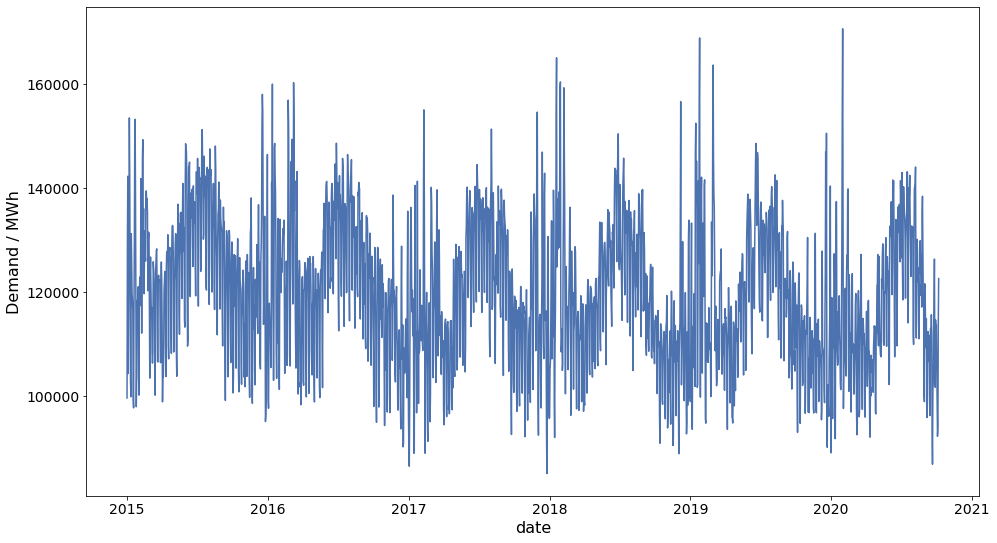

In [12]:
ax = sns.lineplot(data = df, x = 'date', y = 'demand')
ax.set_ylabel('Demand / MWh')

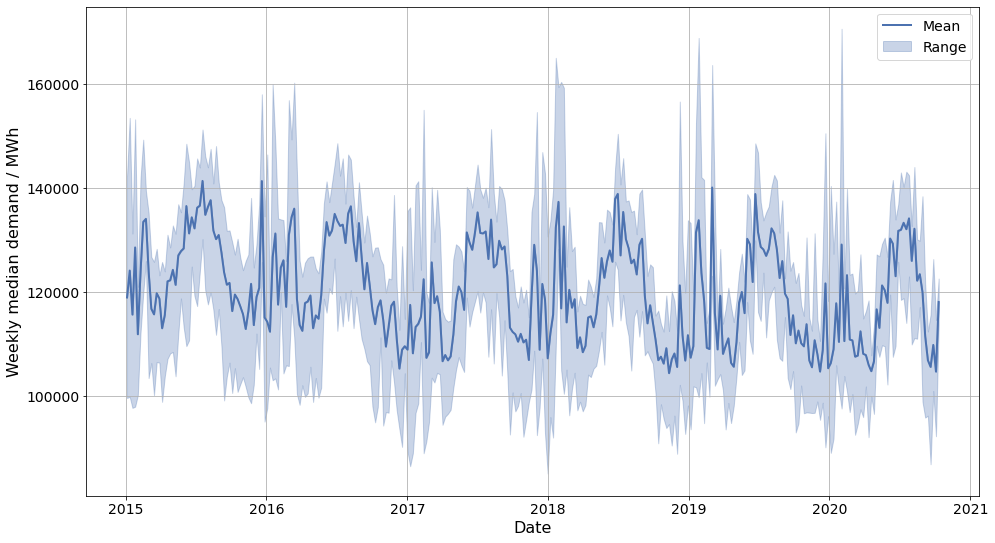

In [13]:
fig, ax = plt.subplots()
sample_window = '1W'
weekly_median = df.resample(sample_window).demand.mean()
weekly_max = df.resample(sample_window).demand.max()
weekly_min = df.resample(sample_window).demand.min()
weekly_mad = df.resample(sample_window).demand.mad()
weekly_std = df.resample(sample_window).demand.std()

ax.plot(weekly_median.index, weekly_median, lw = 2, label = 'Mean')
ax.fill_between(weekly_median.index, weekly_max, weekly_median, alpha = 0.3, color = 'C0', label = 'Range')
ax.fill_between(weekly_median.index, weekly_min, weekly_median, alpha = 0.3,  color = 'C0')

ax.set_ylabel('Weekly median demand / MWh')
ax.set_xlabel('Date')
ax.legend()
ax.grid(True)

### Demand by month


Text(0.5, 0, 'Month')

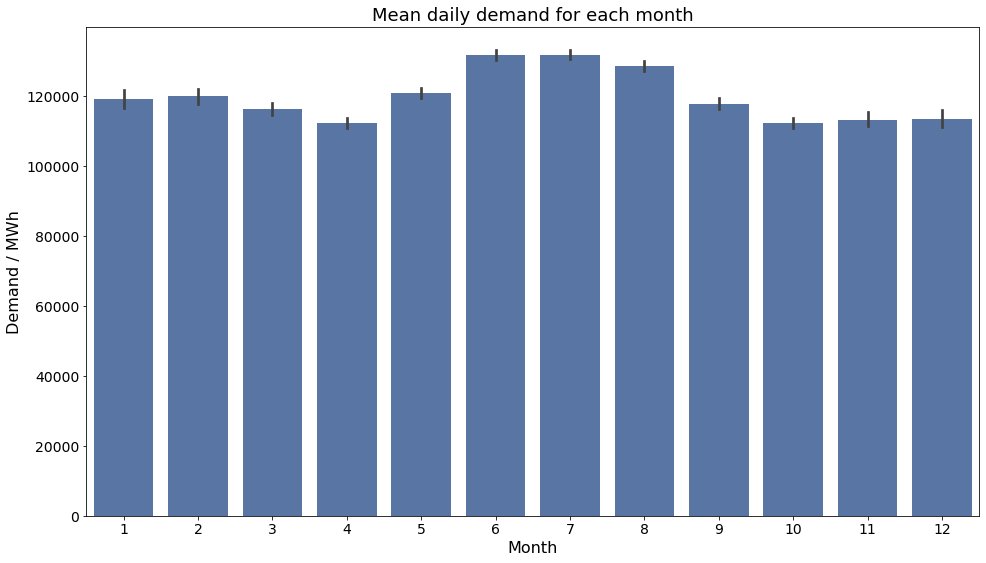

In [14]:
ax = sns.barplot(data = df, y = 'demand', x = 'month', estimator = np.mean, color = 'C0')
ax.set_title('Mean daily demand for each month')
ax.set_ylabel('Demand / MWh')
ax.set_xlabel('Month')

### Demand by year

Text(0.5, 0, 'Year')

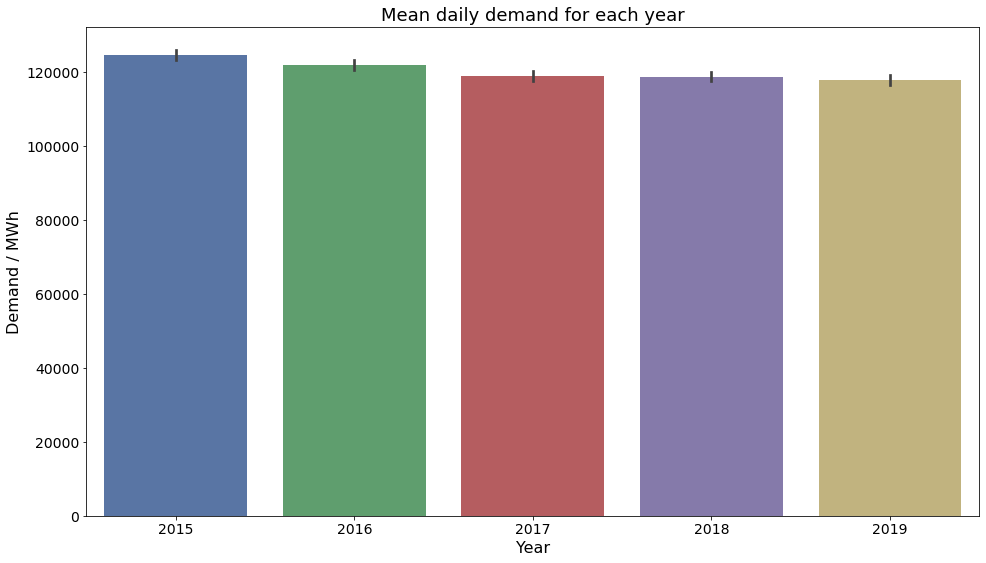

In [15]:
ax = sns.barplot(data = df[df.year != 2020], y = 'demand', x = 'year', estimator = np.mean)
ax.set_title('Mean daily demand for each year')
ax.set_ylabel('Demand / MWh')
ax.set_xlabel('Year')

## Temperatures over time
- Max temperature during winter time dips to below 15 celcius so heating is probably the reason why demand peaks


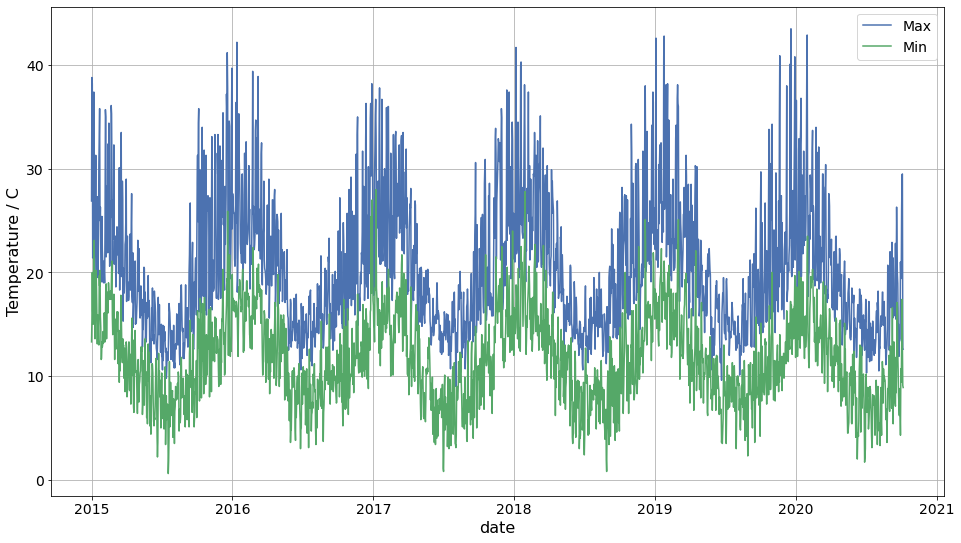

In [16]:
ax = sns.lineplot(data = df, x = 'date', y = 'max_temperature', label = 'Max')
ax = sns.lineplot(data = df, x = 'date', y = 'min_temperature', label = 'Min')
ax.set_ylabel('Temperature / C')
ax.legend()
ax.grid()

## Price over time
- There are very large spikes in data on a few days. Predicting these spikes and selling stored electricity would be profitable (and also help reduce the size of the peaks, thus helping the customer).
- Energy prices increased to a higher level in early 2017 and stayed there until early 2020, at which point the prices came down a bit
- Don't see a very consistent seasonal variation in price even though the demand showed a large change between winter and summer. The changes in supply (or supply cost) must therefore be driving the changes in price rather than demand.
- Could we see seasonal changes if we normalize for median price during the year?


In [17]:
df.groupby('year').price.agg(['mean', 'std'])

,mean,std
year,,
2015,35.068136,14.198412
2016,50.094252,39.770899
2017,94.740161,26.955444
2018,94.648823,75.567797
2019,117.281370,247.196469
2020,61.266055,176.365247


Text(0, 0.5, 'RRP / AUD/MWh')

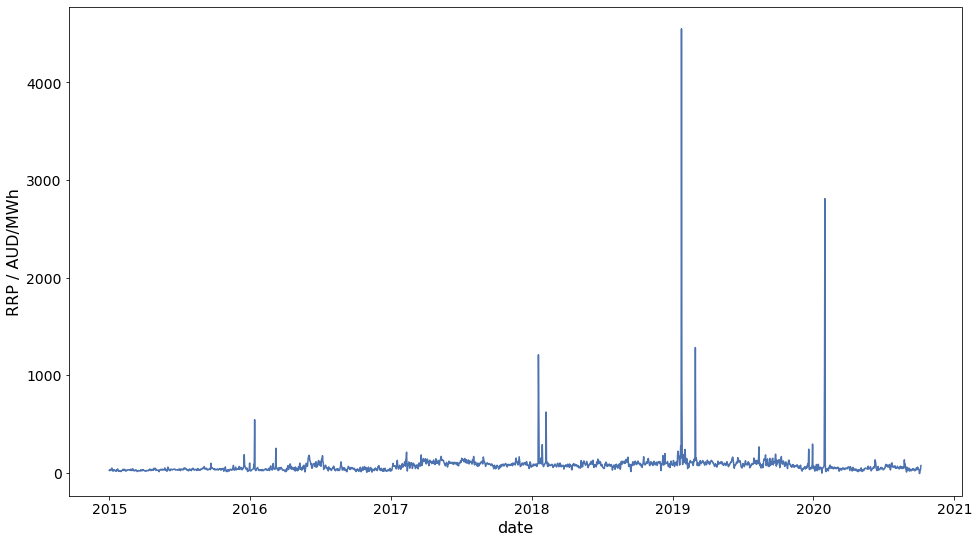

In [18]:
ax = sns.lineplot(data = df, x = 'date', y = 'price')
ax.set_ylabel('RRP / AUD/MWh')

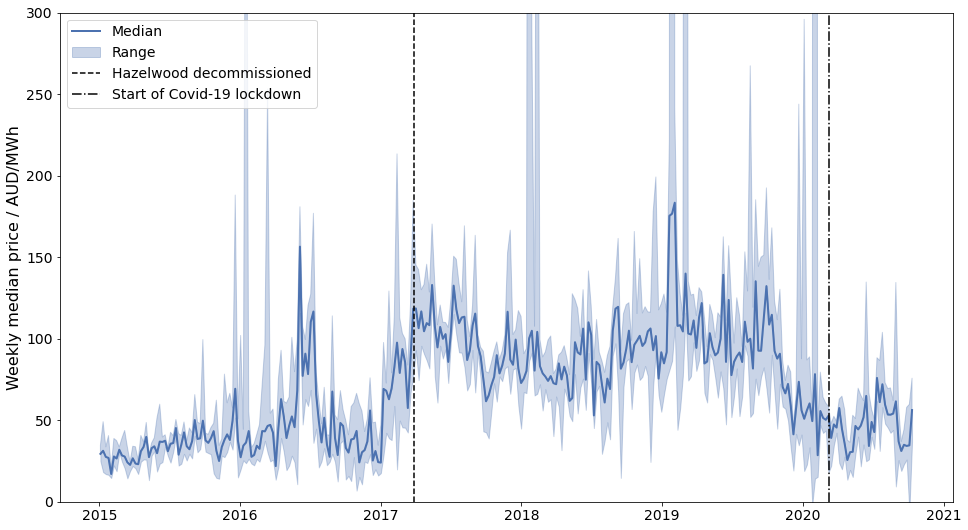

In [19]:
fig, ax = plt.subplots()
sample_window = '1W'
weekly_median = df.resample(sample_window).price.median()
weekly_max = df.resample(sample_window).price.max()
weekly_min = df.resample(sample_window).price.min()
weekly_mad = df.resample(sample_window).price.mad()
weekly_std = df.resample(sample_window).price.std()

ax.plot(weekly_median.index, weekly_median, lw = 2, label = 'Median')
ax.fill_between(weekly_median.index, weekly_max, weekly_median, alpha = 0.3, color = 'C0', label = 'Range')
ax.fill_between(weekly_median.index, weekly_min, weekly_median, alpha = 0.3,  color = 'C0')

# ax.axvline(pd.Timestamp('2019-12-1'), ls = '-.', c = 'k', label = 'First Covid-19 cases in China')
ax.axvline(pd.Timestamp('2017-3-29'), ls = '--', c = 'k', label = 'Hazelwood decommissioned')
ax.axvline(pd.Timestamp('2020-3-10'), ls = '-.', c = 'k', label = 'Start of Covid-19 lockdown')

ax.set_ylabel('Weekly median price / AUD/MWh')
ax.set_ylim([0, 300])
ax.legend()

Text(0.5, 0, 'Year')

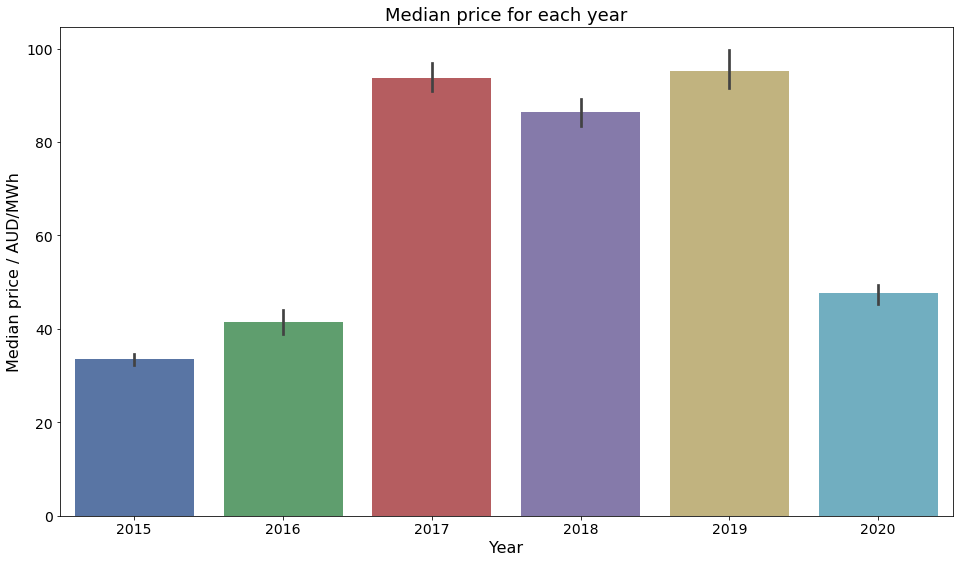

In [20]:
ax = sns.barplot(data = df, y = 'price', x = 'year', estimator = np.median)
ax.set_title('Median price for each year')
ax.set_ylabel('Median price / AUD/MWh')
ax.set_xlabel('Year')

<AxesSubplot:xlabel='year', ylabel='price'>

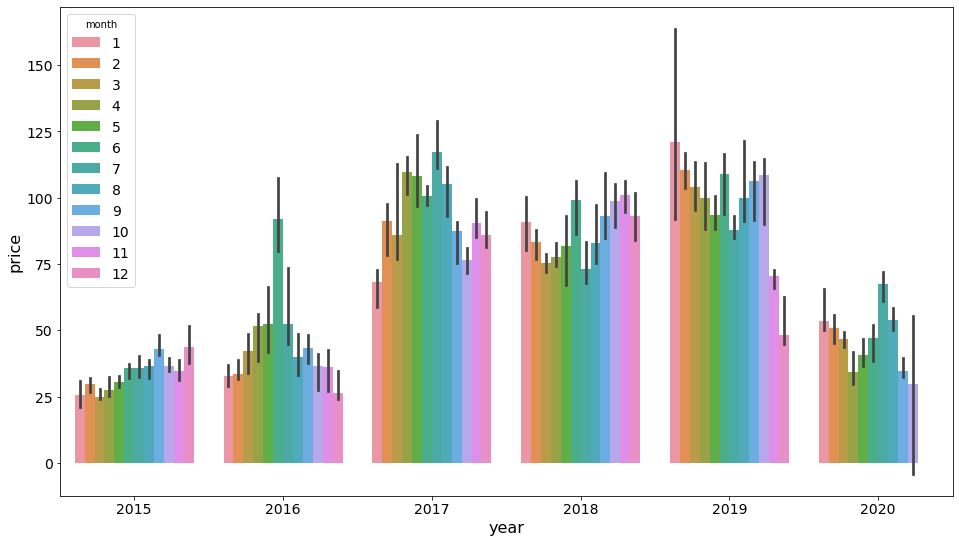

In [21]:
sns.barplot(data = df, y = 'price', x = 'year', hue = 'month', estimator = np.median)

Text(0, 0.5, 'Median absolute deviation from median for price')

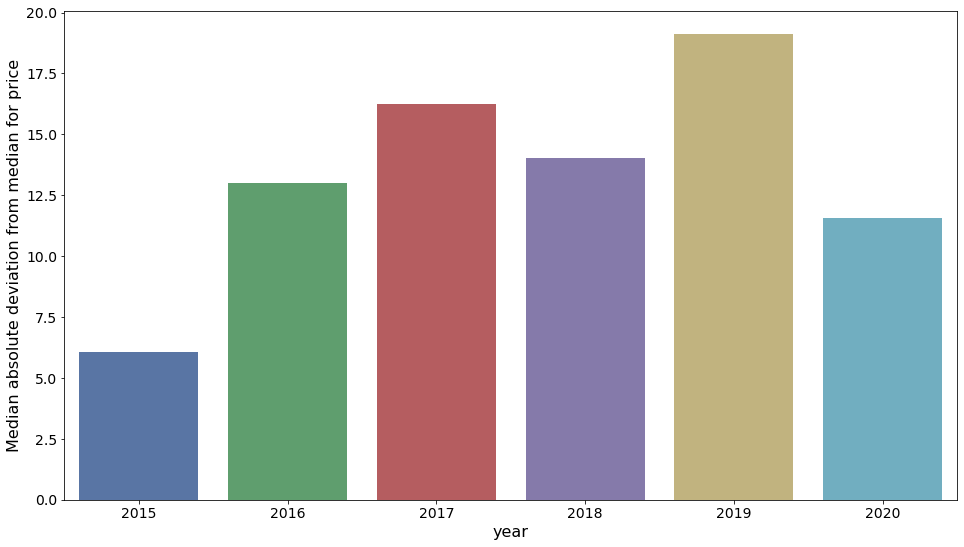

In [22]:
ax = sns.barplot(data = df, y = 'price', x = 'year', estimator = median_abs_deviation, ci = 0)
ax.set_ylabel('Median absolute deviation from median for price')

### Variation in price relative to median

In [23]:
yearly_medians = df.groupby('year').price.mean().to_frame('mean_yearly_price')
df_temp = df.copy()
df_temp = df_temp.merge(yearly_medians, on = 'year')
df_temp['relative_price'] = df_temp.price/df_temp.mean_yearly_price

Text(0, 0.5, 'Price relative to yearly mean')

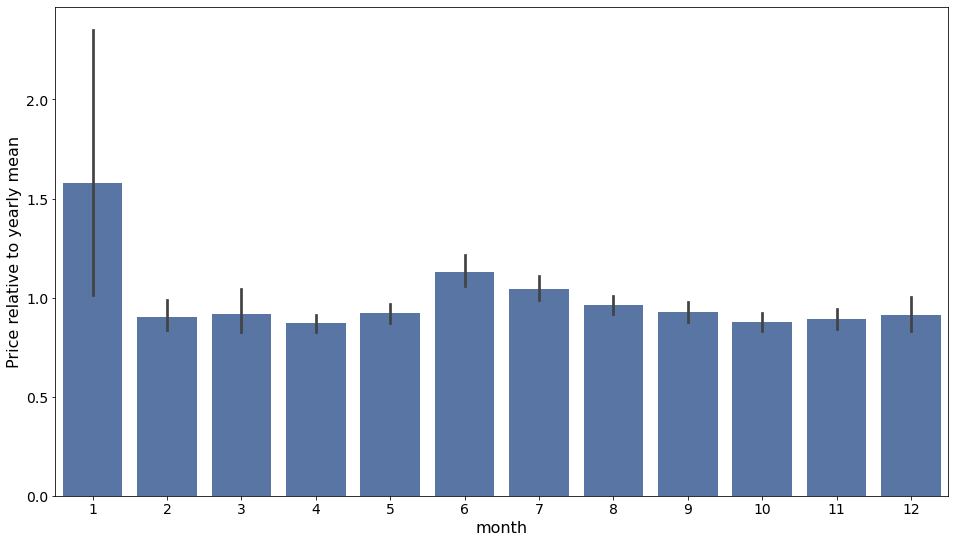

In [24]:
ax = sns.barplot(data = df_temp, y = 'relative_price', x = 'month', estimator = np.mean, color = 'C0')
ax.set_ylabel('Price relative to yearly mean')

### Solar exposure over time
- Solar exposure is highest during the summer when the demand is lowest. Should weight the profits by solar exposure. 

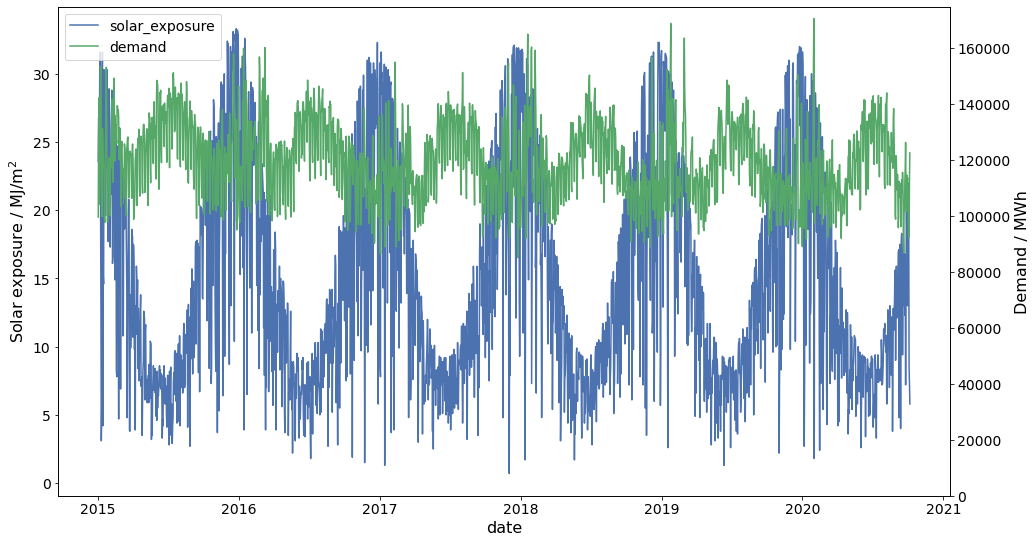

In [25]:
ax = sns.lineplot(data = df, x = 'date', y = 'solar_exposure', label = 'solar_exposure')
ax.set_ylabel(r'Solar exposure / MJ/m$^2$')
ax_twin = ax.twinx()
sns.lineplot(data = df, x = 'date', y = 'demand', ax = ax_twin, label = 'demand', color = 'C1', legend=False)
ax_twin.set_ylim(bottom = 0)
ax_twin.set_ylabel('Demand / MWh')
lines = ax.lines + ax_twin.lines
labels = [l.get_label() for l in lines]

ax.legend(lines, labels)

### Demand for different weekdays

Text(0, 0.5, 'Electricity demand / MWh/Day')

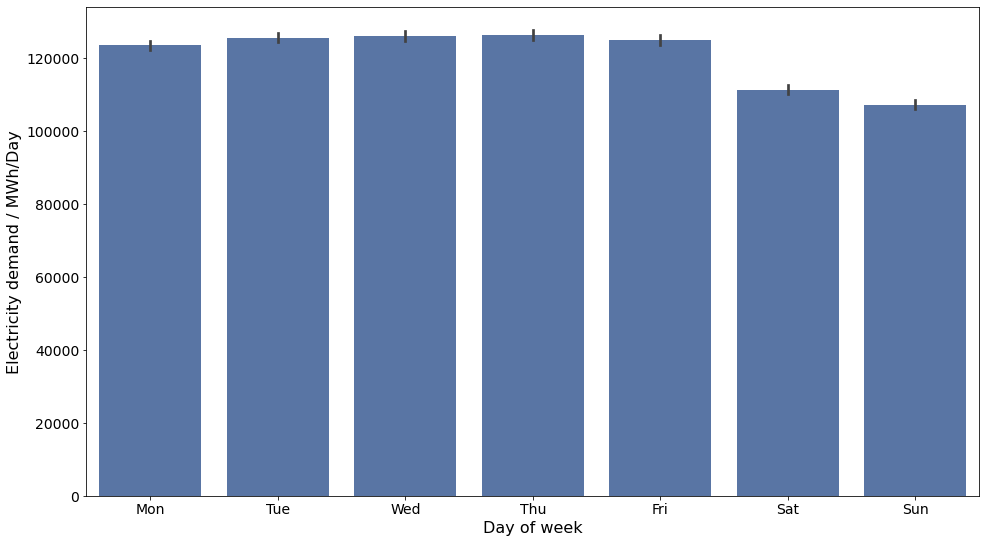

In [30]:
ax = sns.barplot(data = df[~df.holiday], x = 'dow', y = 'demand', color = 'C0')
ax.set_xticks([0,1,2,3,4,5,6],['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
ax.set_xlabel('Day of week')
ax.set_ylabel('Electricity demand / MWh/Day') 

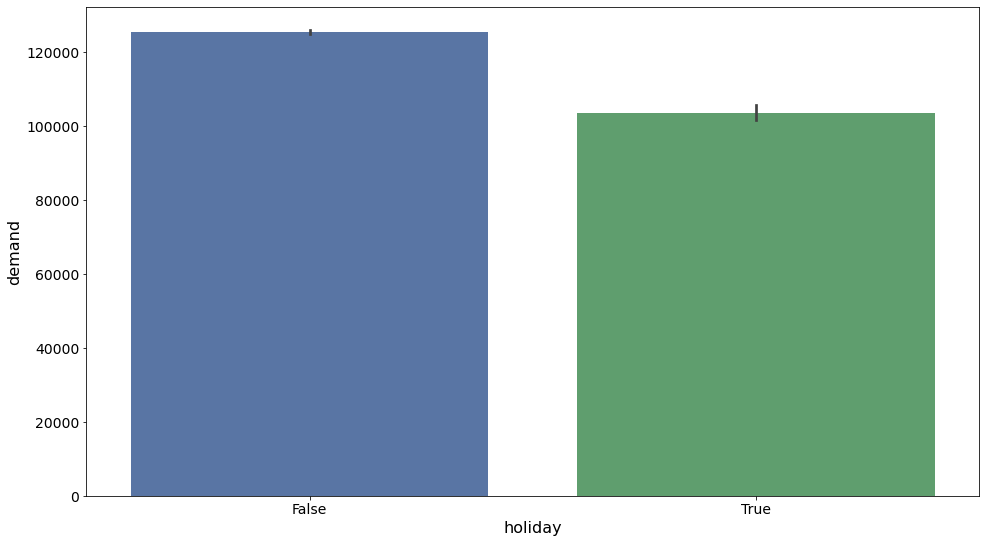

In [162]:
ax = sns.barplot(data = df[~df.dow.isin([5,6])], x = 'holiday', y = 'demand')

### Price for different weekdays

Text(0, 0.5, 'Median electricity price / AUD/MWh')

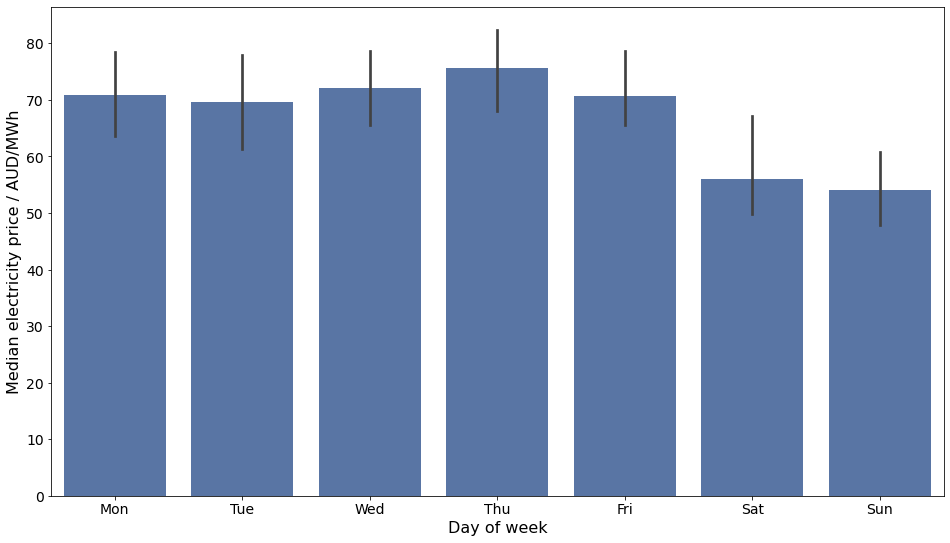

In [32]:
ax = sns.barplot(data = df[~df.holiday], x = 'dow', y = 'price', estimator=np.median, color = 'C0')
ax.set_xticks([0,1,2,3,4,5,6],['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
ax.set_xlabel('Day of week')
ax.set_ylabel('Median electricity price / AUD/MWh') 

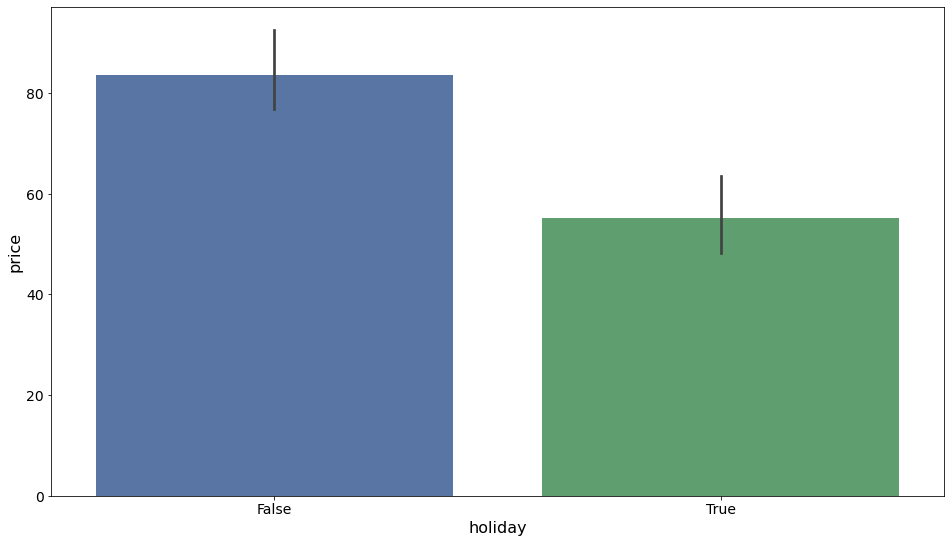

In [165]:
ax = sns.barplot(data = df[~df.dow.isin([5,6])], x = 'holiday', y = 'price')

## Histograms

Text(0.5, 0, 'Price / AUD/MWh')

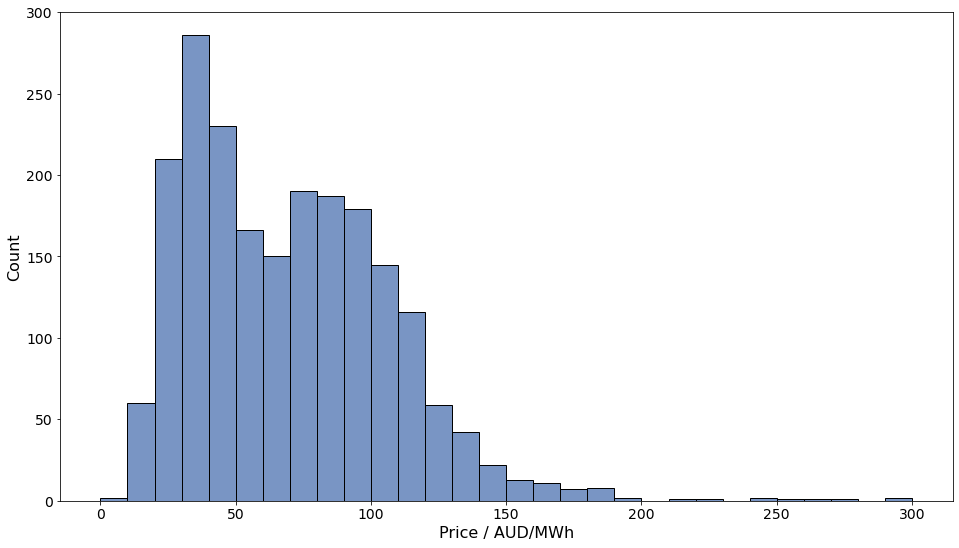

In [129]:
ax = sns.histplot(data = df, x = 'price', bins=np.linspace(0, 300, 31))
ax.set_xlabel('Price / AUD/MWh')

## Correlations

In [130]:
df.corrwith(df.price)

demand              0.217538
price               1.000000
demand_pos_price    0.220856
price_positive      0.999821
demand_neg_price   -0.078815
price_negative      0.038931
frac_neg_price     -0.077955
min_temperature     0.070619
max_temperature     0.165484
solar_exposure      0.061808
rainfall           -0.028642
school_day         -0.005014
holiday            -0.030963
year                0.139880
month              -0.067947
dow                -0.030758
dtype: float64

Try removing the price outliers

In [143]:
df_no_outliers = df[df.price < 3*df.price.median()]

In [144]:
df_no_outliers.corrwith(df_no_outliers.price)

demand              0.245898
price               1.000000
demand_pos_price    0.289040
price_positive      0.997579
demand_neg_price   -0.248545
price_negative      0.116852
frac_neg_price     -0.246340
min_temperature    -0.075656
max_temperature    -0.001859
solar_exposure     -0.049369
rainfall           -0.037359
school_day          0.097267
holiday            -0.076053
year                0.337013
month               0.023184
dow                -0.137848
dtype: float64

### Temperature and price
- The extreme price spikes seem to be on hot days
- Presumably air conditioning is using enough power to outstrip supply, thus causing the price spikes
- If we remove the outliers, there is basically no 

<AxesSubplot:xlabel='max_temperature', ylabel='price'>

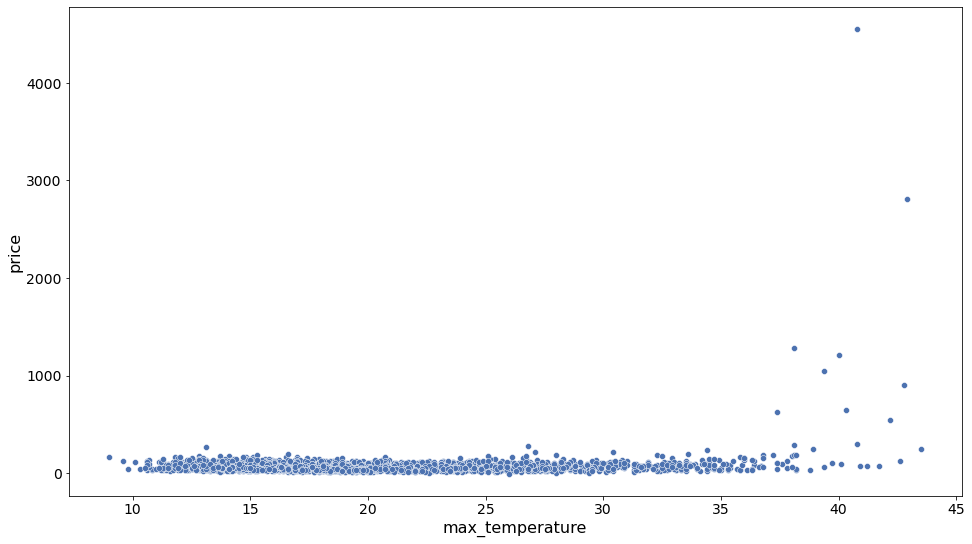

In [137]:
sns.scatterplot(data = df, x = 'max_temperature', y = 'price')

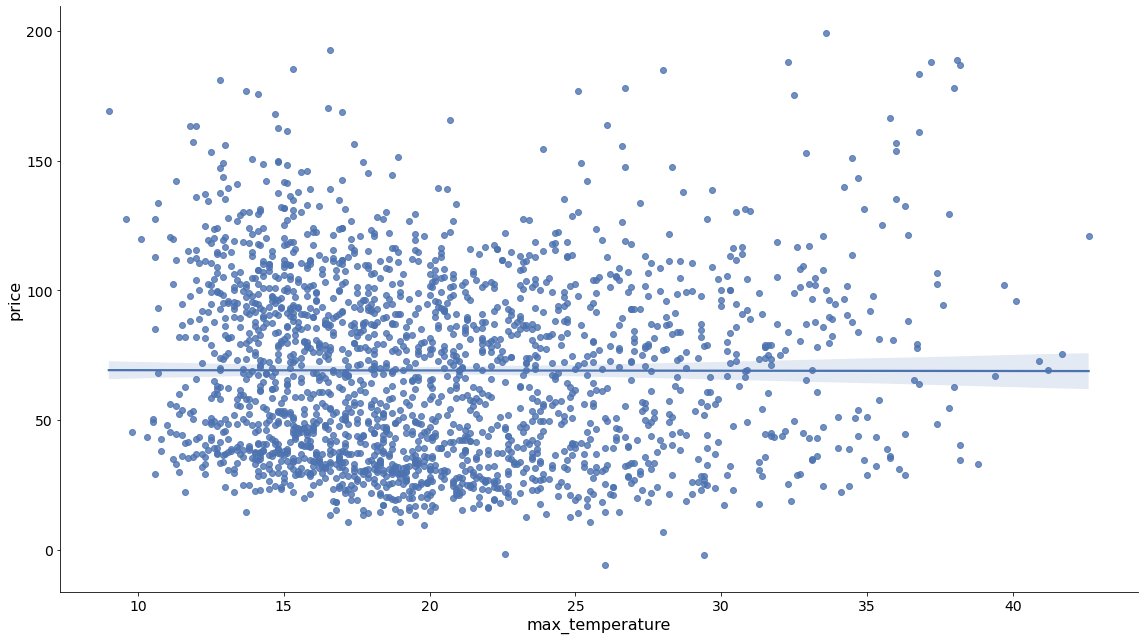

In [151]:
sns.lmplot(data = df[df.price < df.price.median()*3], x = 'max_temperature', y = 'price', height = 9, aspect = 16/9)

### Demand and price
- Price and demand are correlated as one would expect

<AxesSubplot:xlabel='demand', ylabel='price'>

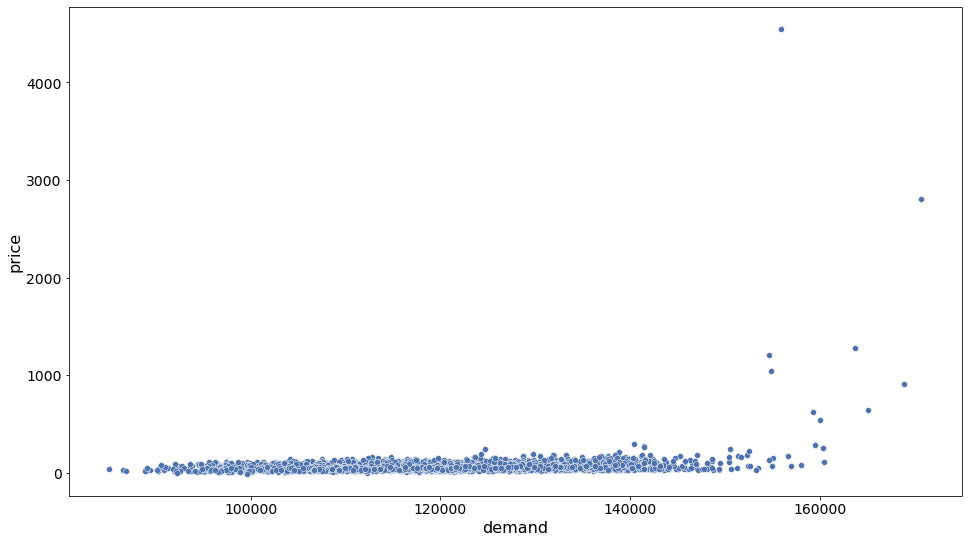

In [138]:
sns.scatterplot(data = df, x = 'demand', y = 'price')

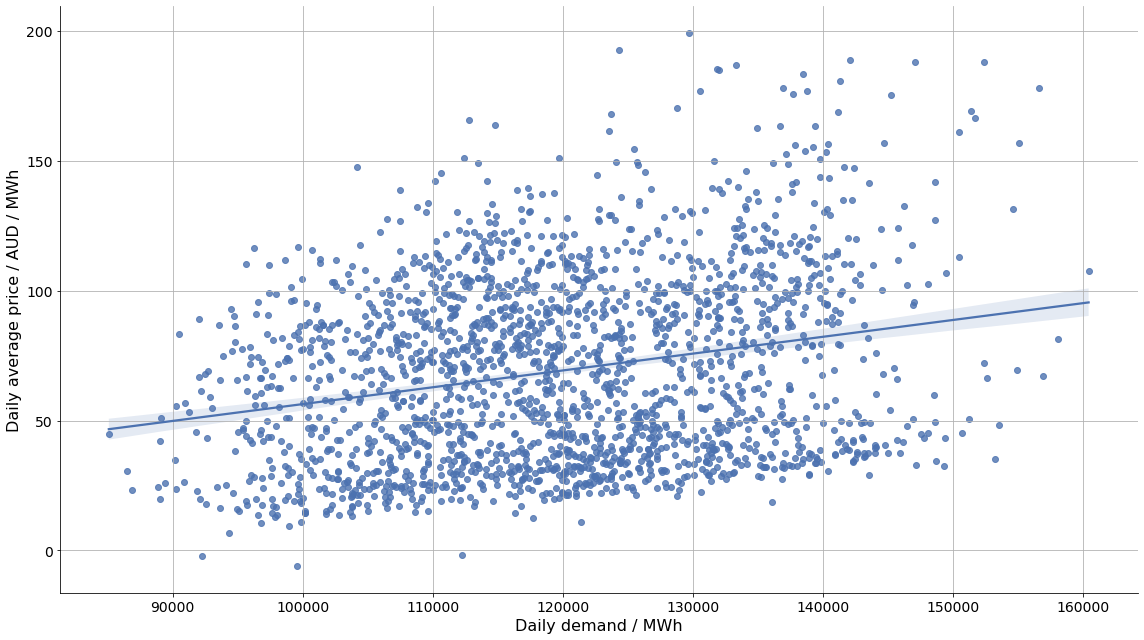

In [158]:
grid = sns.lmplot(data = df[df.price < df.price.median()*3], x = 'demand', y = 'price', height = 9, aspect = 16/9)
grid.axes[0,0].set_xlabel('Daily demand / MWh')
grid.axes[0,0].set_ylabel('Daily average price / AUD / MWh')
grid.axes[0,0].grid(True)

### Solar exposure and temperature

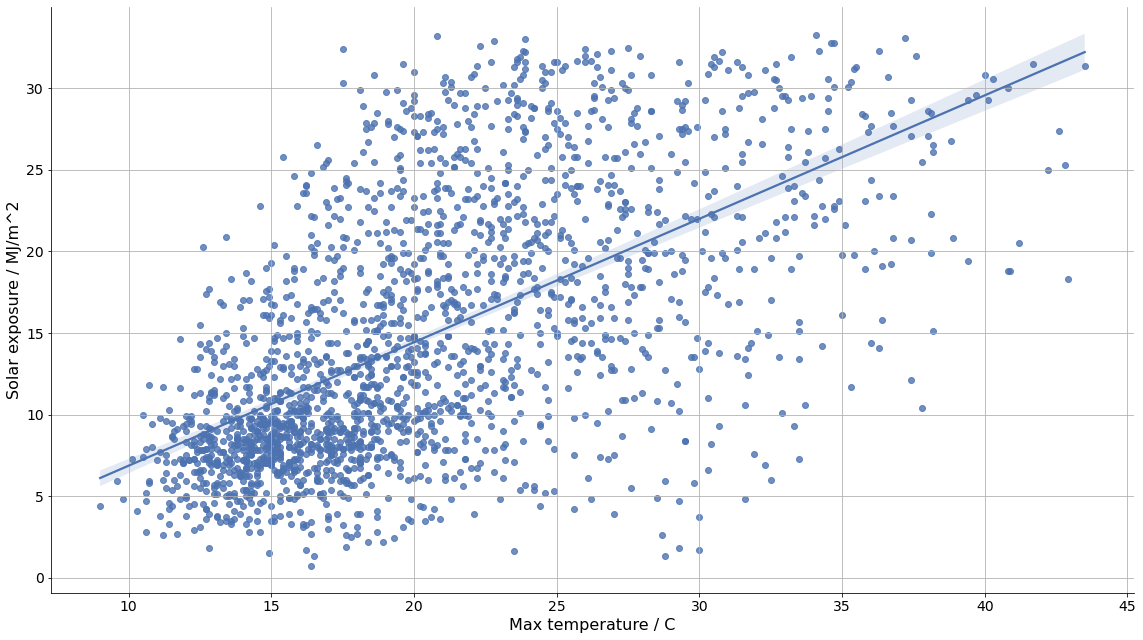

In [206]:
grid = sns.lmplot(data = df, x = 'max_temperature', y = 'solar_exposure', height = 9, aspect = 16/9)
grid.axes[0,0].set_xlabel('Max temperature / C')
grid.axes[0,0].set_ylabel('Solar exposure / MJ/m^2')
grid.axes[0,0].grid(True)